In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper


MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250319-212023-ParentKnowShake_29_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")


venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)


model = PPO.load(MODEL_PATH, 
                 env=venv, 
                 print_system_info=True,
                 custom_objects={
                     "ViT":ViT,
                 })

# f.create_dataset("observations", data=np.array(observations, dtype=np.uint8))
# f.create_dataset("actions", data=np.array(actions))
# f.create_dataset("rewards", data=np.array(rewards))
# f.create_dataset("dones", data=np.array(dones))
# f.create_dataset("seg_observations", data=np.array(seg_observations, dtype=np.uint8))
# f.create_dataset("next_observations", data=np.array(next_observations, dtype=np.uint8))

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

2025-04-22 14:55:06.816282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-22 14:55:06.816344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-22 14:55:06.818385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 14:55:06.827222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 14:55:07.618310: W tensorflow/compiler/tf2

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(10000, 64, 64, 9)


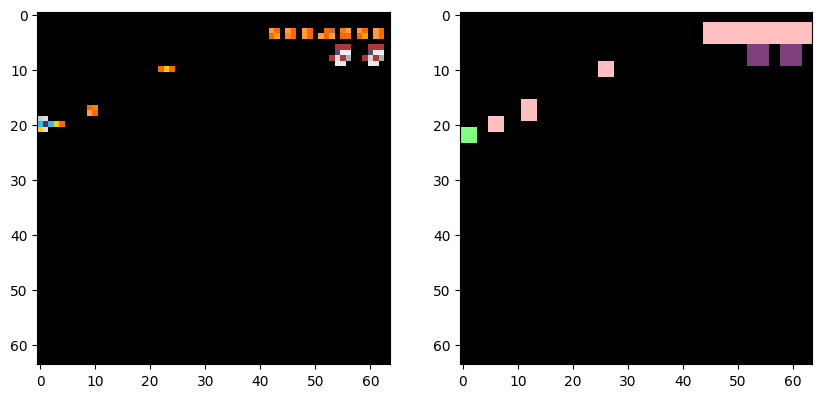

In [2]:
import matplotlib.pyplot as plt

def get_img(obs):
    return obs[:, :, 6:9]

ax, fig = plt.subplots(1, 2, figsize=(10, 5))

fig[0].imshow(get_img(observations[120]))
fig[1].imshow(seg_observations[120])

plt.show()

In [3]:
import imageio
import tqdm

def create_gif(observations, seg_observations, filename='segments.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(seg_observations[i])
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration, loop=0)

filename = "segments.gif"
if not os.path.exists(filename):
    create_gif(observations[:300], seg_observations[:300], filename=filename, duration=0.1)

In [4]:
net = model.policy

net

CustomActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): CustomNetwork(
    (policy_net): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(9, 64, 64))
      (1): ViT(
        (to_patch_embedding): Sequential(
          (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
          (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
          (2): Linear(in_features=144, out_features=64, bias=True)
          (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (transformer): Transformer(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-3): 4 x Mod

In [5]:
# Reshape the observations to match the expected input shape
obs_tensor = th.tensor(observations[:1].reshape((1, -1)), dtype=th.float32, device=net.device)

# Pass the tensor through the action_net
features_a, features_b = net.mlp_extractor(obs_tensor)

print(features_a.shape, features_b.shape)

torch.Size([1, 64]) torch.Size([1, 64])


In [6]:
# Get the action logits
action_logits = net.action_net(features_a)

print(action_logits.shape)

torch.Size([1, 15])


In [7]:
vit = net.mlp_extractor.policy_net
vit

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(9, 64, 64))
  (1): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=144, out_features=64, bias=True)
      (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.1, inpl

In [8]:
observations[:1].shape

(1, 64, 64, 9)

In [9]:
vit = net.mlp_extractor.policy_net[1].cpu()
action_net = net.action_net.cpu()

vit(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cpu())

tensor([[-2.9385, -0.0938,  0.2943, -0.8611, -2.9718, -0.1487,  0.5305, -0.3754,
          6.4303, -0.0625, -0.1271,  0.5112,  0.5273,  0.6188,  0.1304,  1.4204,
         -1.4508, -0.5002,  4.2707, -4.8446, -0.6406, -0.2588, -0.1502,  0.2875,
          0.4556, -0.1207,  3.2186,  0.6250,  1.5897,  0.0406,  1.0383, -2.3100,
         -0.3300, -0.3148,  1.7708,  0.4665, -0.0589, -0.1057,  0.0616,  0.5241,
         -0.1046, -0.3713, -0.0414,  3.5812, -1.0241, -1.2575, -1.6587, -0.0668,
         -0.2665, -0.1336,  0.5238,  6.4026, -0.0739,  1.4751,  0.0587, -0.3893,
         -0.3844, -0.9935,  0.0484,  0.0400,  0.3010,  0.6433,  2.3419,  0.2353]],
       grad_fn=<AddmmBackward0>)

In [10]:
vrobas = action_net(vit(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cpu()))

In [11]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit).cpu()
recorder = Recorder(vit).cpu()

# Emdedding

In [12]:
probas, extracted = extractor(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cpu())

probas.shape, extracted.shape

(torch.Size([1, 64]), torch.Size([1, 257, 64]))

# Attention

In [13]:
probas, attention = recorder(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cpu())

probas.shape, attention.shape

(torch.Size([1, 64]), torch.Size([1, 4, 4, 257, 257]))

In [14]:
import cv2
def attention_map(attention, image):
    # avg attention over heads
    attention = np.array(attention).mean(axis=1)

    grid_size = int(np.sqrt(attention.shape[-1] - 1))
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    reshaped = attention.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = mask / mask.max()
    return mask

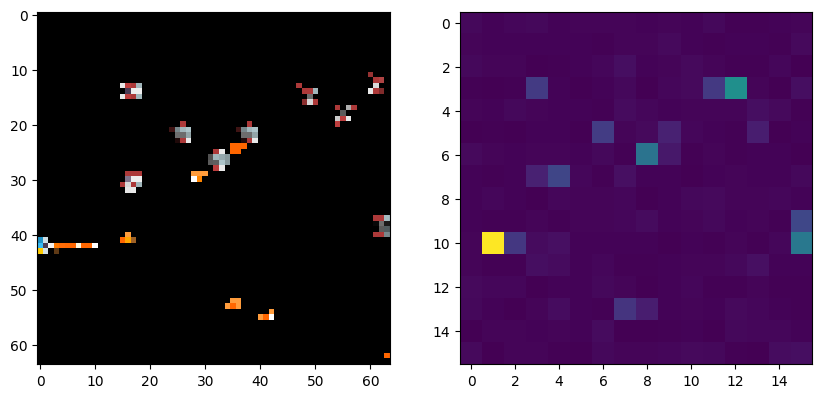

In [15]:
recorder = recorder.cpu()
frame = 304

obs = th.tensor(observations[frame]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()

probas, attention = recorder(obs)

map = attention_map(attention.cpu().detach().numpy(), observations[frame])

# plot both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_img(observations[frame]))
ax[1].imshow(map)

plt.show()

In [16]:
def generate_attention_gif(observations, filename='attention.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        obs = th.tensor(observations[i]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()
        probas, attention = recorder(obs)
        map = attention_map(attention.cpu().detach().numpy(), observations[i])
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(map)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration, loop=0)

filename = "attention.gif"
if not os.path.exists(filename):
    generate_attention_gif(observations[:300], filename=filename)

In [17]:
th.cuda.empty_cache()

# # calculate attention and extract features for all observations
# batch_size = 1
# attention_list = []

# recorder = recorder.cpu()

# for i in tqdm.tqdm(range(0, len(observations), batch_size)):
#     batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cpu()
#     probas, attention = recorder(batch)
#     map = attention_map(attention.cpu().detach().numpy(), observations[i])
#     attention_list.append(map)

#     del batch
#     del probas
#     del attention
    
# attention_list = np.array(attention_list)

In [18]:
seg_observations.shape

(10000, 64, 64, 3)

In [19]:
UNIQUE_COLORS = np.array([[  0,   0,   0],
                            [127,  63, 127],
                            [127,  63, 191],
                            [127, 127, 255],
                            [127, 191,  63],
                            [127, 255, 127],
                            [191, 255, 255],
                            [255, 127, 127],
                            [255, 191, 191],
                            [255, 191, 255]], dtype=np.uint8)

seg_observations_index = np.argmax((seg_observations.reshape(-1, 1, 3) == UNIQUE_COLORS).all(axis=2), axis=1).reshape(seg_observations.shape[0], 64, 64, 1).astype(np.uint8)
seg_observations_index.shape

(10000, 64, 64, 1)

In [20]:
DATASET_SIZE = 5_000

In [21]:
# calculate features using extractor
extractor = extractor.cpu()
batch_size = 1
features_list = []
with th.no_grad():
    for i in tqdm.tqdm(range(0, DATASET_SIZE, batch_size)):
        batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cpu()
        probs, features = extractor(batch)
        features_list.append(features.detach().numpy())

        del batch
        del features

    features_list = np.array(features_list).squeeze()

features_list.shape

  0%|          | 15/5000 [00:00<00:34, 144.20it/s]

100%|██████████| 5000/5000 [00:54<00:00, 92.27it/s] 


(5000, 257, 64)

In [22]:
# (N, 257, 64) -> (N, 16, 16, 64) and cls token removed
features_list = features_list[:, 1:].reshape(-1, 16, 16, 64)

features_list.shape

(5000, 16, 16, 64)

In [23]:
# features are (1000, 16, 16, 64), but we can flatten them to (1000*16*16, 64)
features_list = features_list.reshape(-1, 64)
features_list.shape

(1280000, 64)

In [24]:
features_list[0]

array([-0.43327063, -0.29209712,  0.60423326,  0.5346608 ,  0.6653544 ,
        0.07955822, -0.6449232 ,  0.24359097, -0.01407503,  0.38863006,
       -0.96454793,  0.81493217, -0.3604967 ,  0.73210496, -0.6559737 ,
        0.79990554,  0.6250545 ,  0.8973894 , -0.30437383, -0.46989155,
       -1.0182077 , -0.09854531, -0.4472616 ,  0.6364633 , -0.25614056,
       -0.5418376 ,  0.75689757,  0.12141515, -0.3635496 , -0.21823023,
        0.8002071 ,  0.40962142,  0.93795484, -0.64365274,  0.5916942 ,
       -0.42281878,  1.0389044 ,  0.87767315, -0.48428795, -1.0377052 ,
       -0.294197  ,  0.83971083,  0.2137115 , -1.2034922 , -0.9086437 ,
       -0.17243753, -0.10667486, -0.1058756 , -1.4763657 ,  0.65292734,
        0.06253956,  0.54934216, -0.38479257,  0.88688475, -0.08768519,
        0.5364343 , -0.56455666, -0.76285094,  0.49708563,  0.73503196,
        0.9155322 ,  0.24751318, -0.6360983 , -0.4329095 ], dtype=float32)

In [25]:
seg_observations_index.shape

(10000, 64, 64, 1)

In [26]:
# seg_observations_onehot
# (1000, 64, 64, 14) -> (1000, 16, 16, 14) -> (1000*16*16, 14)

print(seg_observations_index.shape)

seg_observations_index_downsample = seg_observations_index
#        mono = cv2.resize(mono, (16, 16), interpolation=cv2.INTER_NEAREST)
#        mono = np.argmax((mono.reshape(-1, 1, 3) == ProcGenWrapper.UNIQUE_COLORS).all(axis=2), axis=1).reshape(16, 16, 1).astype(np.int32)
import cv2

seg_observations_index_downsample = np.array([cv2.resize(img, (16, 16), interpolation=cv2.INTER_NEAREST) for img in seg_observations_index]).reshape(-1, 16, 16, 1)

seg_observations_index_downsample.shape

(10000, 64, 64, 1)


(10000, 16, 16, 1)

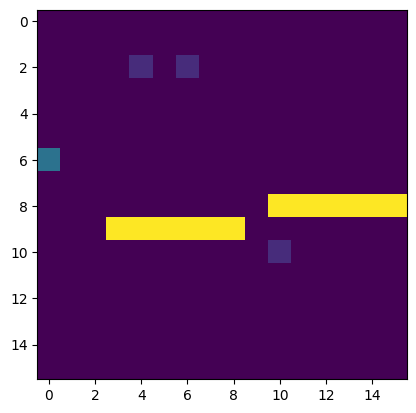

In [27]:
plt.imshow(seg_observations_index_downsample[150]) 

In [28]:
seg_observations_index_downsample.shape

(10000, 16, 16, 1)

In [29]:
seg_observations_index_downsample = seg_observations_index_downsample.reshape(-1, 1)

In [30]:
features_list.shape, seg_observations_index_downsample.shape

((1280000, 64), (2560000, 1))

In [33]:
data_extractor = nn.Sequential(
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
)

X = th.tensor(features_list, dtype=th.float32)
y = th.tensor(seg_observations_index_downsample[:16*16*DATASET_SIZE], dtype=th.float32)

print(X.shape, y.shape)

mask = y != 0
X_masked = X[mask.squeeze()]
y_masked = y[mask.squeeze()]

X_masked = th.cat([X_masked, X[~mask.squeeze()][:int(X_masked.shape[0] * 0.5)]])
y_masked = th.cat([y_masked, y[~mask.squeeze()][:int(y_masked.shape[0] * 0.5)]])

# train the data extractor to predict the segment from the features
dataset_features = th.utils.data.TensorDataset(X_masked, y_masked)

# Repeat the data in the dataset
dataset_features = th.utils.data.ConcatDataset([dataset_features]*2)

train_loader = th.utils.data.DataLoader(dataset_features, batch_size=512, shuffle=True, num_workers=4)

optimizer = th.optim.Adam(data_extractor.parameters(), lr=1e-2)
scheduler = th.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20], gamma=0.1)

epoches = tqdm.tqdm(range(25))
losses = []
for epoch in epoches:
    for features, target in train_loader:
        optimizer.zero_grad()
        output = data_extractor(features)
        # target is int,
        loss = F.cross_entropy(output, target.squeeze().long())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
        if len(losses) > 100:
            epoches.set_description(f"Epoch {epoch} Loss: {np.mean(losses[-100:])}")
        scheduler.step()

torch.Size([1280000, 64]) torch.Size([1280000, 1])


Epoch 24 Loss: 1.2313150811195372: 100%|██████████| 25/25 [01:19<00:00,  3.18s/it]


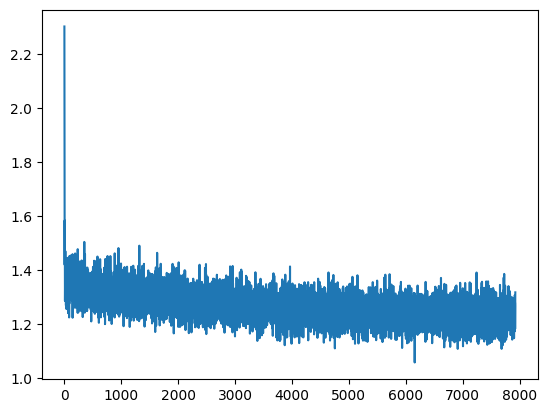

In [34]:
plt.plot(losses)

In [35]:
X.shape

torch.Size([1280000, 64])

In [36]:
# try visualizing the output
output = data_extractor(X)
print(output.shape)
output = output.reshape(-1, 16, 16, 10)
output.shape

torch.Size([1280000, 10])


torch.Size([5000, 16, 16, 10])

In [37]:
output[200][5][5]

tensor([ 2.4192,  1.1684, -1.7642, -0.2690, -2.8085,  0.1737, -1.2457, -2.3189,
         2.3066, -3.5138], grad_fn=<SelectBackward0>)

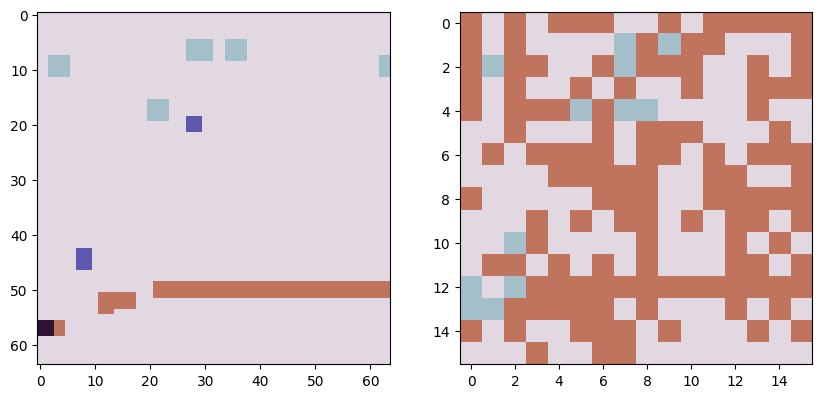

In [38]:
# display
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

I = 200
ax[0].imshow(seg_observations_index[I].squeeze(), cmap="twilight", vmin=0, vmax=10)
ax[1].imshow(output[I].detach().numpy().argmax(axis=2), cmap="twilight", vmin=0, vmax=10)

In [39]:
# make animation out of seg_observations_index and output

def create_segmentation_gif(observations, segmentations, filename='segmentations_first.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(segmentations[i].argmax(axis=2), cmap="twilight", vmin=0, vmax=13)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration, loop=0)

filename = "segmentations_first-2.gif"
if not os.path.exists(filename):
    create_segmentation_gif(observations[:300], output.detach().numpy(), filename=filename)

100%|██████████| 300/300 [00:26<00:00, 11.35it/s]


In [40]:
# try training on rgb
seg_observations

seg_observations_downsampled = np.array([cv2.resize(img, (16, 16), interpolation=cv2.INTER_NEAREST) for img in seg_observations]).reshape(-1, 3)

X = th.tensor(features_list, dtype=th.float32)
y = th.tensor(seg_observations_downsampled[:16*16*DATASET_SIZE], dtype=th.float32)
y = y / 255.0

print(X.shape, y.shape)

torch.Size([1280000, 64]) torch.Size([1280000, 3])


In [41]:
data_extractor = nn.Sequential(
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
)

print(X.shape, y.shape)


# train the data extractor to predict the segment from the features
dataset_features = th.utils.data.TensorDataset(X, y)

# Repeat the data in the dataset
dataset_features = th.utils.data.ConcatDataset([dataset_features]*2)

train_loader = th.utils.data.DataLoader(dataset_features, batch_size=512, shuffle=True, num_workers=4)

optimizer = th.optim.Adam(data_extractor.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 2], gamma=0.1)

epoches = tqdm.tqdm(range(3))
losses_old_rgb_trained = []
for epoch in epoches:
    for features, target in train_loader:
        optimizer.zero_grad()
        output = data_extractor(features)
        # target is int,
        loss = F.mse_loss(output, target)
        losses_old_rgb_trained.append(loss.item())
        loss.backward()
        optimizer.step()

        if len(losses_old_rgb_trained) > 100 and len(losses_old_rgb_trained) % 10 == 0:
            epoches.set_description(f"Epoch {epoch} Loss: {np.mean(losses_old_rgb_trained[-100:])}")
        scheduler.step()

torch.Size([1280000, 64]) torch.Size([1280000, 3])


Epoch 2 Loss: 0.019446655381470918: 100%|██████████| 3/3 [01:55<00:00, 38.55s/it]


In [42]:
output_rgb_old = data_extractor(X[:16*16*300])
output_rgb_old = output_rgb_old.detach().numpy().reshape(-1, 16, 16, 3)
output_rgb_old.shape

(300, 16, 16, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.004255254..0.19844925].


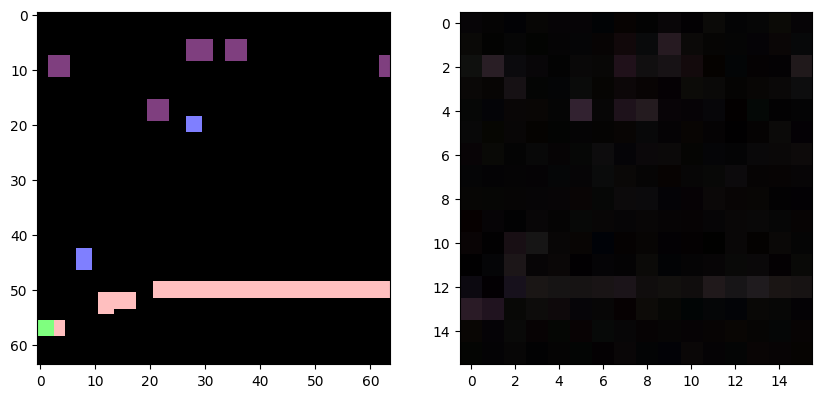

In [43]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

I = 200
ax[0].imshow(seg_observations[I])
ax[1].imshow(output_rgb_old[I, :, :, :])

In [44]:
def create_rgb_gif(observations, segmentations, filename='rgb.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        seg = segmentations[i].reshape(16, 16, 3)
        seg = np.clip(seg, 0, 1)
        ax[1].imshow(seg)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration, loop=0)

filename = "segmentations_old_rgb-2.gif"

if not os.path.exists(filename):
    create_rgb_gif(observations[:300], output_rgb_old, filename=filename)

100%|██████████| 300/300 [00:25<00:00, 11.92it/s]


In [45]:
FILE_NAME = "/home/lord225/pyrepos/explain-rl/models/20250326-140543-DrugRedMessage_90_v3.1"

model = PPO.load(FILE_NAME,
                    env=venv, 
                    print_system_info=True,
                    custom_objects={
                        "ViT":ViT,
                    })
net = model.policy
vit = net.mlp_extractor.policy_net[1]
vit

== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=144, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Layer

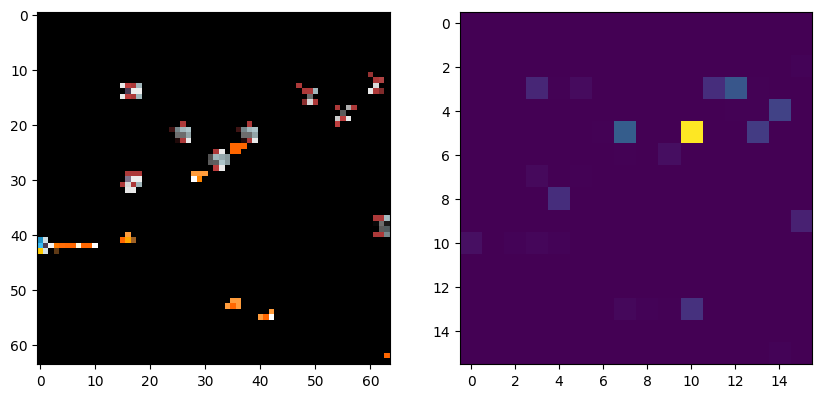

In [46]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

recorder = Recorder(vit)
recorder = recorder.cpu()

frame = 304

obs = th.tensor(observations[frame]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()

probas, attention = recorder(obs)

map = attention_map(attention.cpu().detach().numpy(), observations[frame])

# plot both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_img(observations[frame]))
ax[1].imshow(map)

plt.show()

In [47]:
# create gif
filename = "attention_new.gif"
if not os.path.exists(filename):
    generate_attention_gif(observations[:300], filename=filename)


In [48]:
import tqdm
from vit_pytorch.extractor import Extractor


extractor = Extractor(vit).cpu()

batch_size = 1
features_list = []
DATASET_SIZE = 5_000
with th.no_grad():
    for i in tqdm.tqdm(range(0, DATASET_SIZE, batch_size)):
        batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cpu()
        probs, features = extractor(batch)
        features_list.append(features.cpu().detach().numpy())

        del batch
        del features

    features_list = np.array(features_list).squeeze()

100%|██████████| 5000/5000 [02:24<00:00, 34.61it/s]  


In [49]:
features_list.shape

(5000, 257, 64)

In [50]:
features_list = features_list[:, 1:].reshape(-1, 64)
features_list.shape

(1280000, 64)

In [52]:
data_extractor = nn.Sequential(
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 14),
)

X = th.tensor(features_list, dtype=th.float32)
y = th.tensor(seg_observations_index_downsample[:16*16*DATASET_SIZE], dtype=th.float32)

print(X.shape, y.shape)

mask = y != 0
X_masked = X[mask.squeeze()]
y_masked = y[mask.squeeze()]

X_masked = th.cat([X_masked, X[~mask.squeeze()][:int(X_masked.shape[0] * 0.5)]])
y_masked = th.cat([y_masked, y[~mask.squeeze()][:int(y_masked.shape[0] * 0.5)]])

# train the data extractor to predict the segment from the features
dataset_features = th.utils.data.TensorDataset(X_masked, y_masked)

# Repeat the data in the dataset
dataset_features = th.utils.data.ConcatDataset([dataset_features]*2)

train_loader = th.utils.data.DataLoader(dataset_features, batch_size=512, shuffle=True, num_workers=4)

optimizer = th.optim.Adam(data_extractor.parameters(), lr=1e-2)
scheduler = th.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20], gamma=0.1)

epoches = tqdm.tqdm(range(25))
losses_seg_trained = []
for epoch in epoches:
    for features, target in train_loader:
        optimizer.zero_grad()
        output = data_extractor(features)
        # target is int,
        loss = F.cross_entropy(output, target.squeeze().long())
        losses_seg_trained.append(loss.item())
        loss.backward()
        optimizer.step()

        if len(losses_seg_trained) > 100:
            epoches.set_description(f"Epoch {epoch} Loss: {np.mean(losses_seg_trained[-100:])}")
        scheduler.step()

torch.Size([1280000, 64]) torch.Size([1280000, 1])


Epoch 24 Loss: 0.9718155956268311: 100%|██████████| 25/25 [02:01<00:00,  4.85s/it]


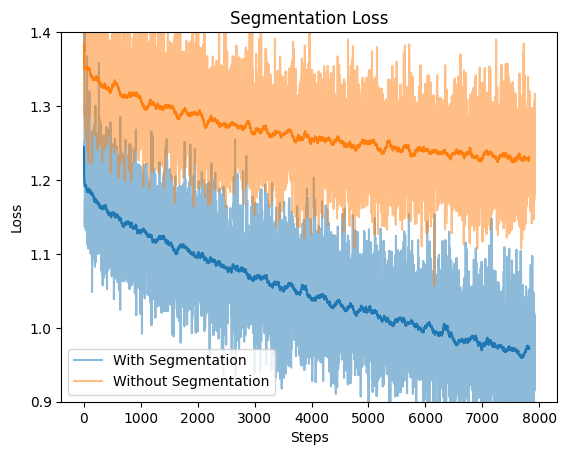

In [69]:
plt.plot(losses_seg_trained, alpha=0.5, color="tab:blue", label="With Segmentation")
plt.plot(np.convolve(losses_seg_trained, np.ones(100)/100, mode='valid'), color="tab:blue")

plt.plot(losses, alpha=0.5,color="tab:orange", label="Without Segmentation")
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'), color="tab:orange")

plt.title("Segmentation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0.9, 1.4)
plt.show()

In [54]:

output_seg_tuned = data_extractor(X.reshape(-1, 16, 16, 64)[:300])
print(output.shape)

torch.Size([354, 14])


In [55]:
# make animation out of seg_observations_index and output

def create_segmentation_gif(observations, segmentations, filename='segmentations_secomd.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(segmentations[i].argmax(axis=2), cmap="twilight", vmin=0, vmax=13)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration, loop=0)

filename = "segmentations_second-2.gif"
if not os.path.exists(filename):
    create_segmentation_gif(observations[:300], output_seg_tuned.detach().numpy(), filename=filename)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:33<00:00,  8.91it/s]


In [56]:
seg_observations_downsampled = np.array([cv2.resize(img, (16, 16), interpolation=cv2.INTER_NEAREST) for img in seg_observations]).reshape(-1, 3)

X = th.tensor(features_list, dtype=th.float32)
y = th.tensor(seg_observations_downsampled[:16*16*5000], dtype=th.float32)
y = y / 255.0

print(X.shape, y.shape)

torch.Size([1280000, 64]) torch.Size([1280000, 3])


In [57]:
# remove samples where y == (0, 0, 0)

mask = (y != 0).all(axis=1)

X_masked = X[mask.squeeze()]
y_masked = y[mask.squeeze()]


X_masked.shape, y_masked.shape

(torch.Size([54049, 64]), torch.Size([54049, 3]))

In [58]:
data_extractor = nn.Sequential(
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
)

print(X.shape, y.shape)


dataset_features = th.utils.data.TensorDataset(X, y)

dataset_features = th.utils.data.ConcatDataset([dataset_features]*2)

train_loader = th.utils.data.DataLoader(dataset_features, batch_size=512, shuffle=True, num_workers=4)

optimizer = th.optim.Adam(data_extractor.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 2], gamma=0.1)

epoches = tqdm.tqdm(range(3))
losses_rgb_trained = []
for epoch in epoches:
    for features, target in train_loader:
        optimizer.zero_grad()
        output = data_extractor(features)
        # target is int,
        loss = F.mse_loss(output, target)
        losses_rgb_trained.append(loss.item())
        loss.backward()
        optimizer.step()

        if len(losses_rgb_trained) > 100 and len(losses_rgb_trained) % 10 == 0:
            epoches.set_description(f"Epoch {epoch} Loss: {np.mean(losses_rgb_trained[-100:])}")
        scheduler.step()

torch.Size([1280000, 64]) torch.Size([1280000, 3])


Epoch 2 Loss: 0.01452640145085752: 100%|██████████| 3/3 [01:47<00:00, 35.92s/it] 


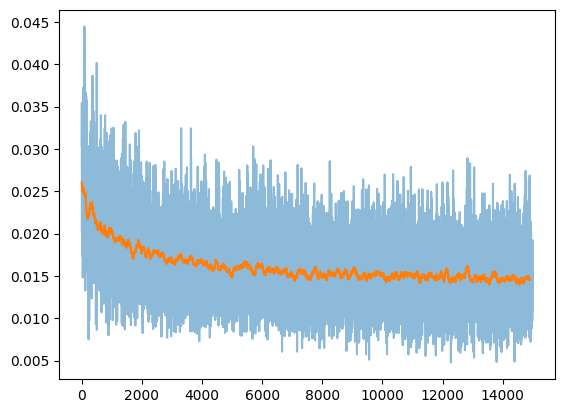

In [59]:
plt.plot(losses_rgb_trained, alpha=0.5)
plt.plot(np.convolve(losses_rgb_trained, np.ones(100)/100, mode='valid'))

In [60]:
output_rgb_tuned = data_extractor(X[:16*16*300])
output_rgb_tuned = output_rgb_tuned.detach().numpy().reshape(-1, 16, 16, 3)
output_rgb_tuned.shape

(300, 16, 16, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04338062..0.6279108].


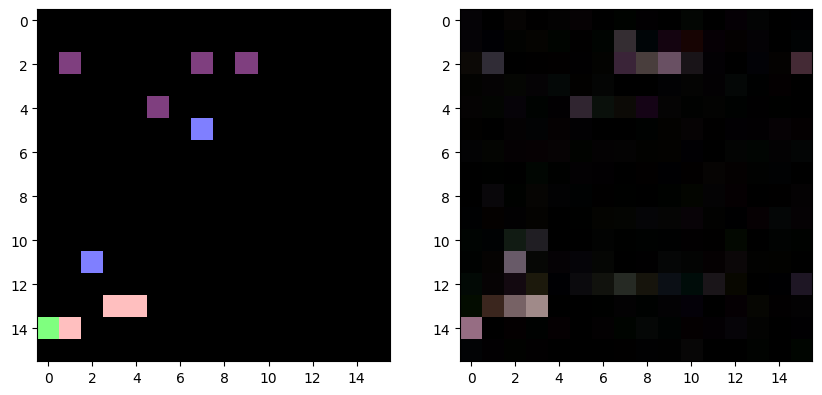

In [61]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

I = 200
ax[0].imshow(y.reshape(-1, 16, 16, 3)[I, :, :, :])
ax[1].imshow(output_rgb_tuned[I, :, :, :])

In [62]:
# generate gif
filename = "rgb_tuned-2.gif"

if not os.path.exists(filename):
    create_rgb_gif(observations[:300], output_rgb_tuned, filename=filename)

100%|██████████| 300/300 [00:25<00:00, 11.74it/s]
